## Import Modules

In [1]:
#import modules required
import re, math
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm, ensemble
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

### Load in Data

In [2]:
# load training dataset
prefix = "TSOA_PIP"
training_data=f"{prefix}_train.csv"
train_data=pd.read_csv(training_data)
Descs=train_data.columns[1:-1]
train_desc=train_data[Descs]

### Calculate and plot the correlation between all of the descriptors

In [3]:
#correlation between variables
def corr_graph(Data,title):
    #get correlation table
    corr=Data.corr()
    #convert to R^2
    corr=corr.pow(2)
    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=0, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(Data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(Data.columns)
    ax.set_yticklabels(Data.columns)
    #y parameter move title up to be legible
    ax.set_title("Correlation Table - " + title,y=1.15)
    plt.savefig(f'{prefix}_Descriptor_Correlations.jpg')
    plt.show()
    #Find descriptors with R^2 > 0.9
    #using numpy, get values
    arr = corr.values
    index_names = corr.index
    col_names = corr.columns

    #  Get indices where such threshold is crossed; avoid diagonal elems
    R,C = np.where(np.triu(arr,1)>0.9)

    # Arrange those in columns and put out as a dataframe
    out_arr = np.column_stack((index_names[R],col_names[C],arr[R,C]))
    df_corr = pd.DataFrame(out_arr,columns=[['row_name','col_name','R2']])
    return df_corr

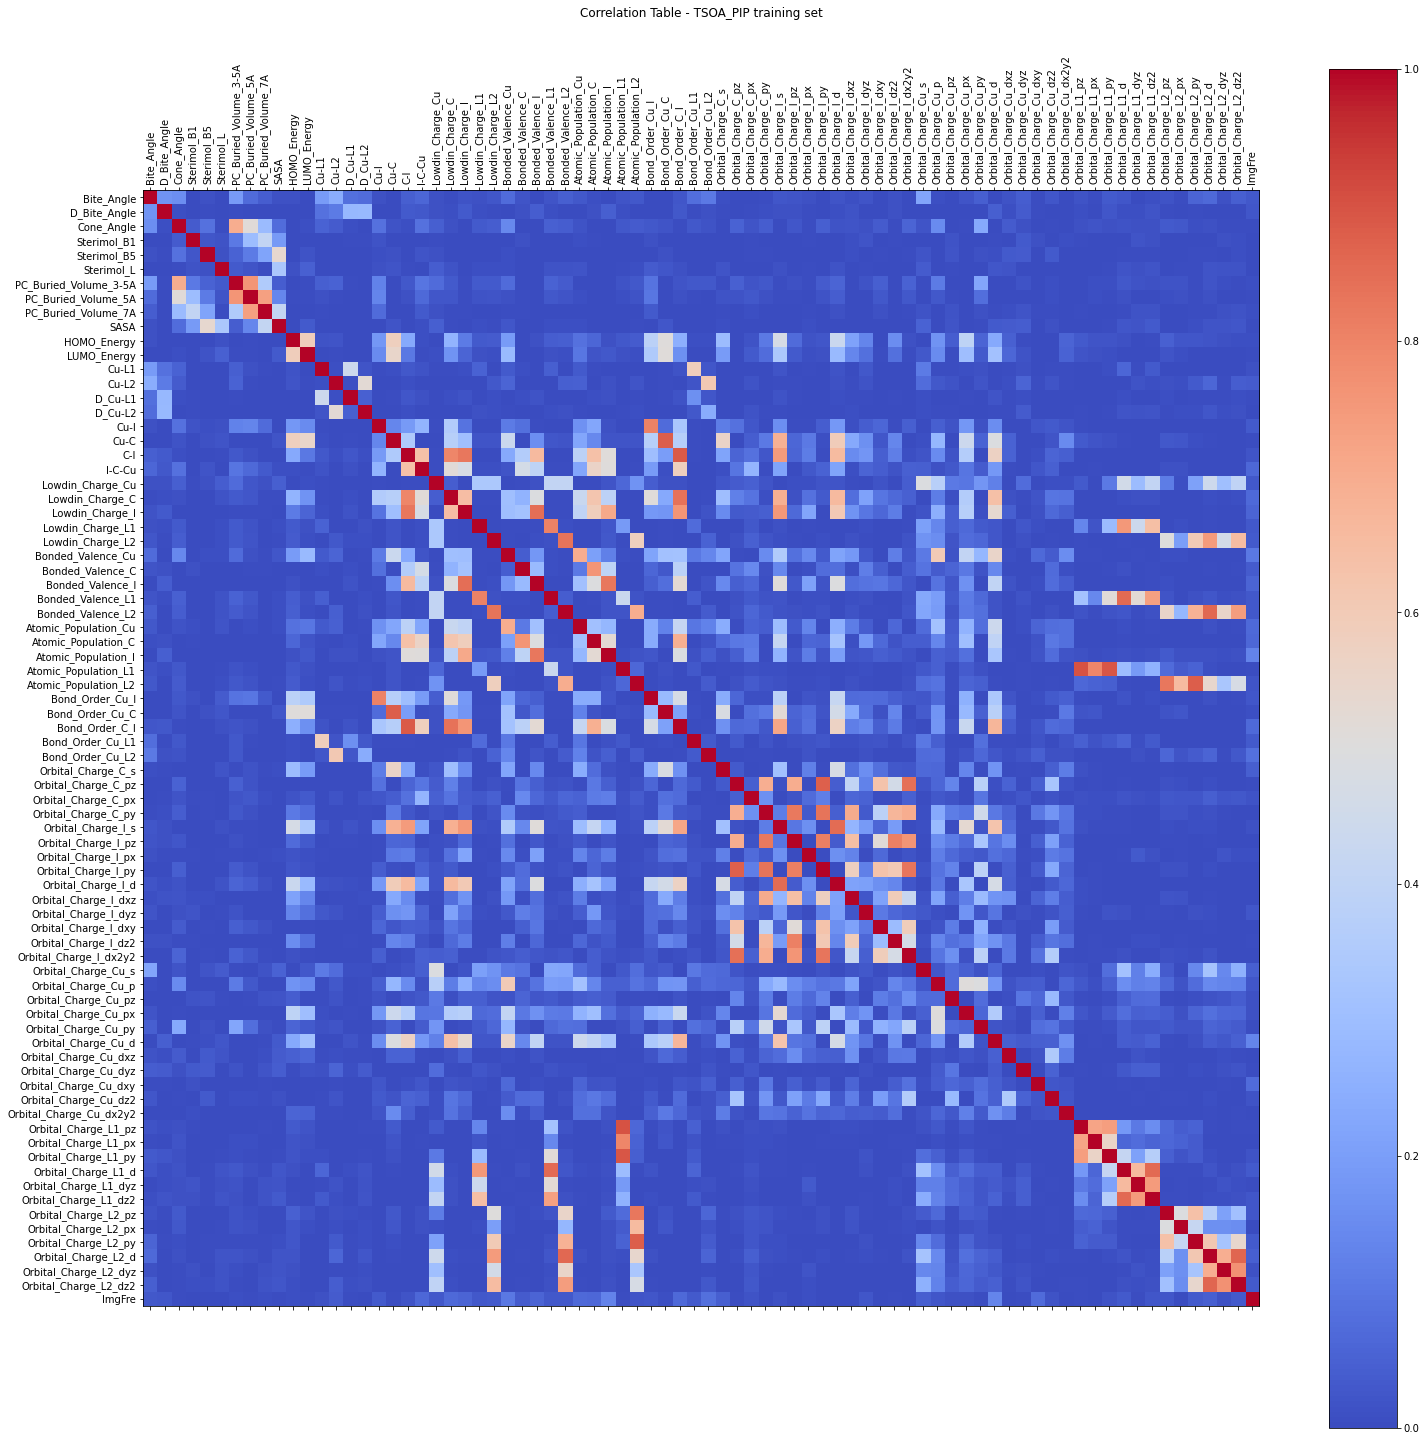

,row_name,col_name,R2


In [4]:
corr_graph(train_desc,f"{prefix} training set")

### The correlation between descriptors seems obvious. So CnC and all differences/ratios were removed before fitting.

### Define functions to calculate metrics

In [5]:
#define RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
#define method to find predictions within certain range
def within_range(list1, list2, range2):
    x=0
    for i in range(len(list2)):
        if (list1[i]-range2)<= list2[i] <= (list1[i]+range2): 
            x+=1
    return (float(x) / (len(list2))) * 100

### Define function to run all of the machine learning models

In [6]:
#Stat Split Method
def stat_split_metrics(train,test,descs,c,epsilon,gamma):
    RMSE=[]
    R2=[]
    N4=[]
    N2=[]
    #place target value in y
    y_train = train['Ea']
    y_test = test['Ea']
    #place descriptors in X
    X_train = train[descs]
    X_test = test[descs]
    #scale data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #run models
    #MLR
    mlr = LinearRegression()
    mlr.fit(X_train, y_train)
    mlr2preds = mlr.predict(X_test)
    #evaluate model
    R2.append(pearsonr(mlr2preds, y_test))
    RMSE.append(rmse(mlr2preds, y_test))
    N4.append(within_range(y_test,mlr2preds,4))
    N2.append(within_range(y_test,mlr2preds,2))
    #GPR
    #gpr2preds = gpr(train, test, descs)
    gpr_kernel = kernels.Matern()
    gpr = GaussianProcessRegressor(kernel=gpr_kernel)
    gpr.fit(X_train, y_train)
    gpr2preds = gpr.predict(X_test)
    R2.append(pearsonr(gpr2preds, y_test))
    RMSE.append(rmse(gpr2preds, y_test))
    N4.append(within_range(y_test,gpr2preds,4))
    N2.append(within_range(y_test,gpr2preds,2))
    #ANN
    mlp = MLPRegressor(hidden_layer_sizes=400, max_iter=800)
    mlp.fit(X_train, y_train)
    mlp2preds = mlp.predict(X_test)
    #evaluate model
    R2.append(pearsonr(mlp2preds, y_test))
    RMSE.append(rmse(mlp2preds, y_test))
    N4.append(within_range(y_test,mlp2preds,4))
    N2.append(within_range(y_test,mlp2preds,2))
    #SVM
    svm2 = svm.SVR(C=c, epsilon=epsilon, gamma=gamma, kernel='rbf')
    svm2.fit(X_train, y_train)
    svm2preds = svm2.predict(X_test)
    #evaluate model
    R2.append(pearsonr(svm2preds, y_test))
    RMSE.append(rmse(svm2preds, y_test))
    N4.append(within_range(y_test,svm2preds,4))
    N2.append(within_range(y_test,svm2preds,2))
    #PLS
    pls2 = PLSRegression(n_components=9)
    pls2.fit(X_train, y_train)
    pls2preds = pls2.predict(X_test)
    #evaluate model
    #convert to float (comes in weird type?)
    pls2preds2=[]
    for i in pls2preds:
        pls2preds2.append(float(i))
    R2.append(pearsonr(pls2preds2, y_test))
    RMSE.append(rmse(pls2preds2, y_test))
    N4.append(within_range(y_test,pls2preds2,4))
    N2.append(within_range(y_test,pls2preds2,2))
    #RF
    tree2 = ensemble.RandomForestRegressor(n_estimators=200, n_jobs=-1)
    tree2.fit(X_train, y_train)
    tree2preds = tree2.predict(X_test)
    #evaluate model
    R2.append(pearsonr(tree2preds, y_test))
    RMSE.append(rmse(tree2preds, y_test))
    N4.append(within_range(y_test,tree2preds,4))
    N2.append(within_range(y_test,tree2preds,2))
    #ExtraTrees
    tree3 = ensemble.ExtraTreesRegressor(n_estimators=200, n_jobs=-1)
    tree3.fit(X_train, y_train)
    tree3preds = tree3.predict(X_test)
    #evaluate model
    R2.append(pearsonr(tree3preds, y_test))
    RMSE.append(rmse(tree3preds, y_test))
    N4.append(within_range(y_test,tree3preds,4))
    N2.append(within_range(y_test,tree3preds,2))
    #Bagging
    tree4 = ensemble.BaggingRegressor(n_estimators=200,n_jobs=-1)
    tree4.fit(X_train, y_train)
    tree4preds = tree4.predict(X_test)
    #evaluate model
    R2.append(pearsonr(tree4preds, y_test))
    RMSE.append(rmse(tree4preds, y_test))
    N4.append(within_range(y_test,tree4preds,4))
    N2.append(within_range(y_test,tree4preds,2))
    #get R2 from Pearson output
    R2_2=[]
    for i in range(len(R2)):
        x=re.findall('\d\.\d+',str(R2[i]))
        j=float(x[0])
        j=j**2
        R2_2.append(j)
    #create dataframe of metrics
    Models=["MLR","GPR","ANN","SVM","PLS","RF","ExtraTrees","Bagging"]
    Metrics=list(zip(Models,R2_2,RMSE,N4,N2))
    Metrics_df=pd.DataFrame(data=Metrics, columns=['Model','R2','RMSE','% within 4.0','% within 2.0'])
    indiv_preds=list(zip(test['Ligand'],mlr2preds,gpr2preds,mlp2preds,svm2preds,pls2preds,tree2preds,tree3preds,tree4preds,y_test))
    indiv_preds_df=pd.DataFrame(data=indiv_preds, columns=["Ligand","MLR","GPR","ANN","SVM","PLS","RF","ExtraTrees","Bagging","Calc"])
    return Metrics_df, indiv_preds_df


In [7]:
# load datasets
train_set=pd.read_csv(training_data)
test_data=f"{prefix}_test.csv"
test_set=pd.read_csv(test_data)
new_descs=test_set.columns[1:-1]
train_set_decs=train_set[new_descs]
test_set_decs=test_set[new_descs]

### Self validation test
We now use the same data for test set and training set

In [8]:
metrics, preds=stat_split_metrics(train_set,test_set,new_descs,c=6,epsilon=1,gamma=0.02)

In [9]:
metrics

,Model,R2,RMSE,% within 4.0,% within 2.0
0,MLR,0.394213,8.640267,58.823529,32.480818
1,GPR,0.249870,9.701227,72.890026,49.872123
2,ANN,0.449310,8.548184,61.381074,40.920716
3,SVM,0.329761,9.142999,74.424552,54.987212
4,PLS,0.437630,8.311873,60.102302,35.294118
5,RF,0.427165,8.441861,74.168798,53.196931
6,ExtraTrees,0.493977,7.897048,75.447570,53.964194
7,Bagging,0.413827,8.557407,73.145780,52.941176


### Checking predictions vs experimental data

In [10]:
preds

,Ligand,MLR,GPR,ANN,SVM,PLS,RF,ExtraTrees,Bagging,Calc
0,BEHZOD,0.367083,-0.747815,-5.724184,6.882834,[5.487296750947229],-3.6455,-4.3925,-3.1680,-18.0
1,IYAYAK,18.619646,22.752360,25.396976,21.426334,[17.56844553674398],28.2085,25.1425,26.7310,-16.8
2,HIFWOI,-1.202602,4.007411,0.045490,10.386845,[7.839991442783589],1.3430,2.5340,1.5835,-15.7
3,GASKUG,-1.799919,1.000154,-3.504392,8.153898,[7.0693993352555164],-9.4200,-10.2850,-11.1100,-14.3
4,VACYIH,24.424769,0.184736,-7.727913,17.912045,[3.0140547586815387],-1.3435,-3.4330,-1.0300,-8.6
...,...,...,...,...,...,...,...,...,...,...
386,MUMNOZ,20.313503,22.420568,21.205543,22.946090,[20.71905208052084],22.3015,23.0125,22.9700,64.3
387,KUHKOP,9.594553,18.442616,33.666209,18.798303,[22.382892939412514],18.7095,27.9050,19.0690,65.7
388,ORUXEF,25.410299,19.257824,35.466930,19.106827,[24.822256237970777],21.2065,21.1265,21.2840,71.4
389,KEBJIM,26.480761,13.604416,30.441421,17.740374,[25.528532563793533],51.8480,39.6660,46.1660,81.9


### Define function and plot ML metric graphs

In [11]:
#Graph methods
def graphs(x,y,method,train_size,test_size,fig_num):
    #find min and max to determine axes and lines
    num_list=[]
    num_list.extend(x)
    num_list.extend(y)
    mini=math.floor(min(num_list))
    maxi=math.ceil(max(num_list))
    ax=fig.add_subplot(4, 2, fig_num)
    plt.scatter(x,y)
    line = mlines.Line2D([mini,maxi], [mini, maxi], color='red')
    line1 = mlines.Line2D([mini,maxi - 4], [mini + 4, maxi], color='red')
    line2 = mlines.Line2D([mini + 4,maxi], [mini, maxi - 4], color='red')
    ax.add_line(line)
    ax.add_line(line1)
    ax.add_line(line2)
    plt.title(f"Calculated vs Predicted Ea using {method} :\nT = {str(train_size)} , S = {str(test_size)}")
    plt.xlabel("Calculated Ea (kcal/mol)")
    plt.ylabel("Predicted Ea (kcal/mol)")
    plt.xlim(mini,maxi)
    plt.ylim(mini,maxi)
    plt.grid(True)
    
def graphs_landscape(x,y,method,train_size,test_size,fig_num):
    #find min and max to determine axes and lines
    num_list=[]
    num_list.extend(x)
    num_list.extend(y)
    mini=math.floor(min(num_list))
    maxi=math.ceil(max(num_list))
    ax=fig.add_subplot(2, 4, fig_num)
    plt.scatter(x,y)
    line = mlines.Line2D([mini,maxi], [mini, maxi], color='red')
    line1 = mlines.Line2D([mini,maxi - 4], [mini + 4, maxi], color='red')
    line2 = mlines.Line2D([mini + 4,maxi], [mini, maxi - 4], color='red')
    ax.add_line(line)
    ax.add_line(line1)
    ax.add_line(line2)
    plt.title(f"Calculated vs Predicted Ea using {method} :\nT = {str(train_size)} , S = {str(test_size)}")
    plt.xlabel("Calculated Ea (kcal/mol)")
    plt.ylabel("Predicted Ea (kcal/mol)")
    plt.xlim(mini,maxi)
    plt.ylim(mini,maxi)
    plt.grid(True)

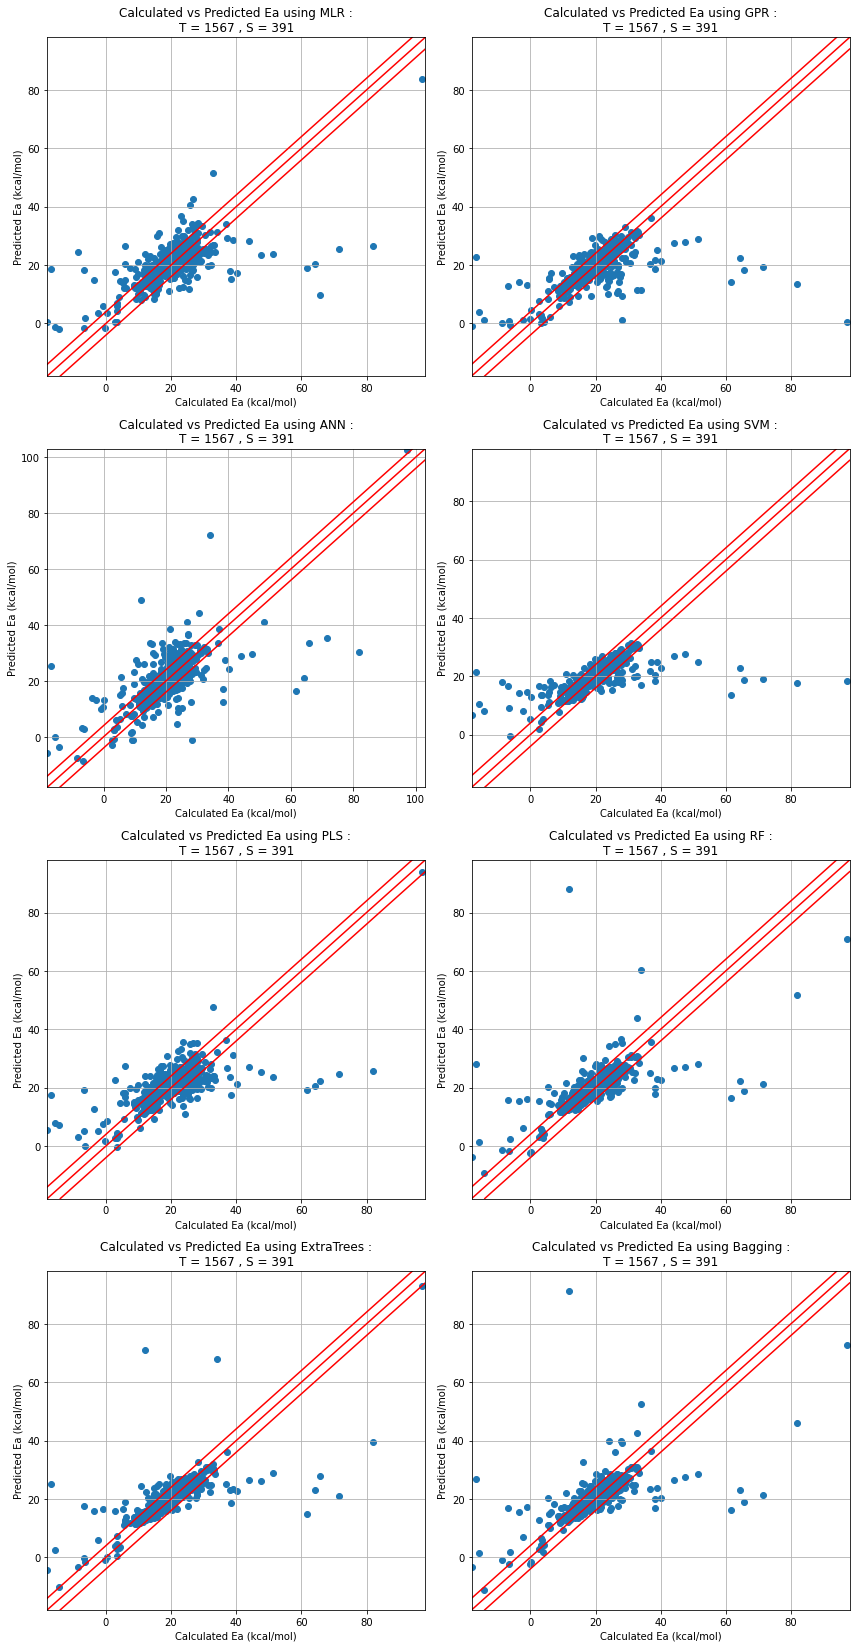

In [12]:
#graphs
models=["MLR","GPR","ANN","SVM","PLS","RF","ExtraTrees","Bagging"]
fig=plt.figure(figsize=(12,23))
i=1
for x in models:
    graphs(preds['Calc'],preds[x],x,len(train_set),len(test_set),i)
    i=i+1
plt.tight_layout()
plt.savefig(f'{prefix}_ML_Graphs_Portrait.jpg')
plt.show()

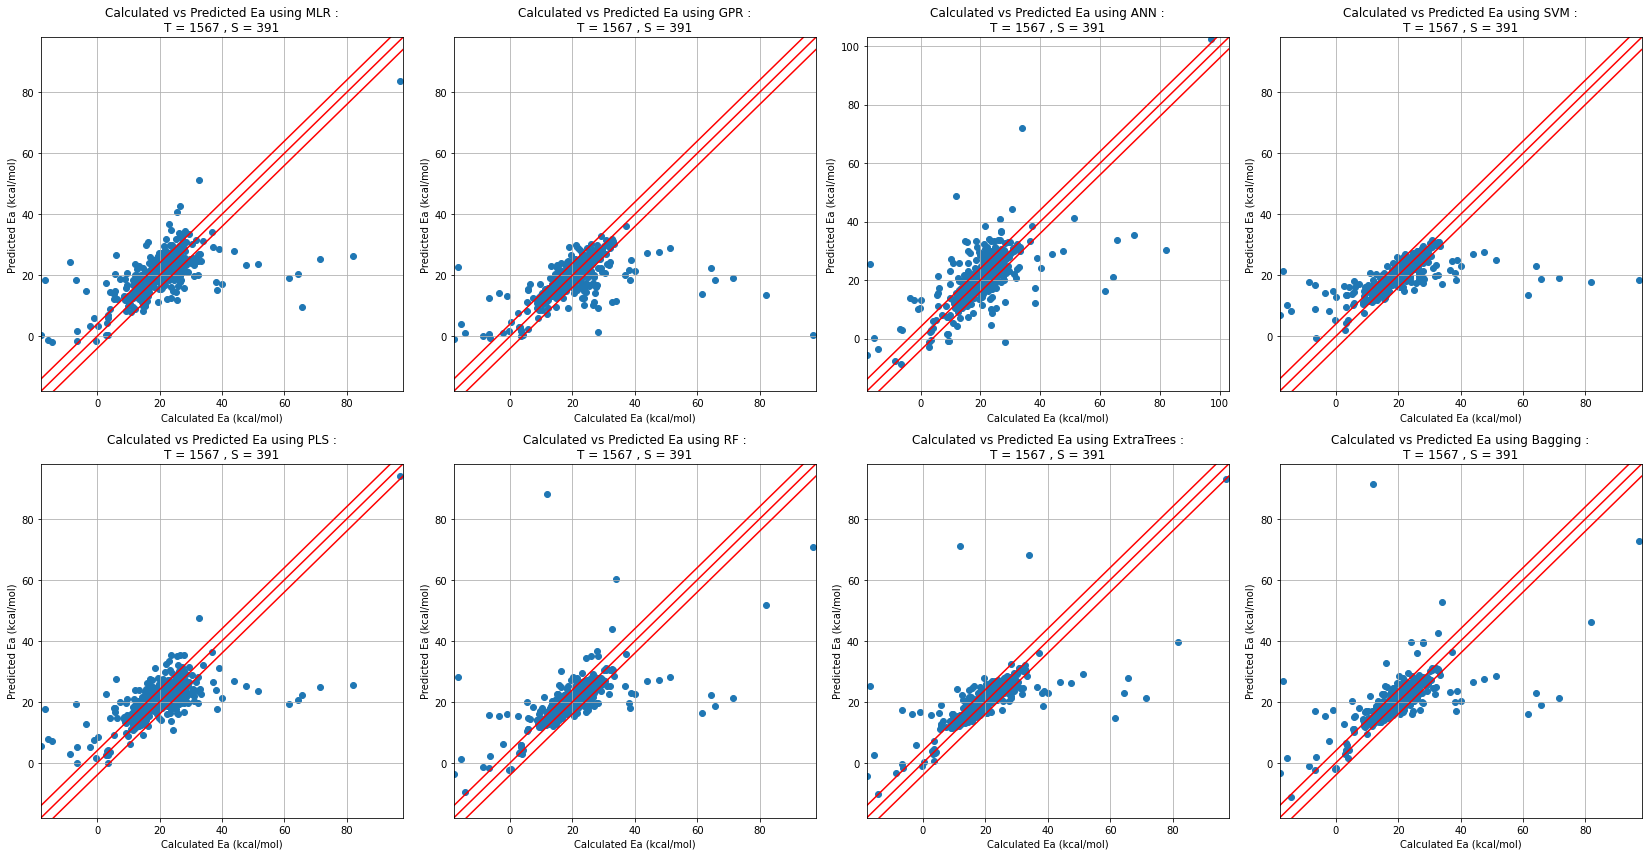

In [13]:
fig=plt.figure(figsize=(23,12))
i=1
for x in models:
    graphs_landscape(preds['Calc'],preds[x],x,len(train_set),len(test_set),i)
    i=i+1
plt.tight_layout()
plt.savefig(f'{prefix}_ML_Graphs_Landscape.jpg')
plt.show()

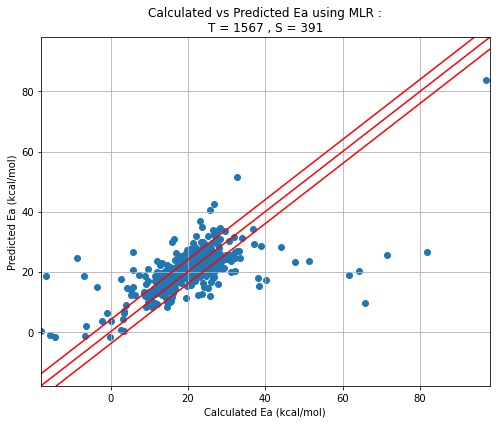

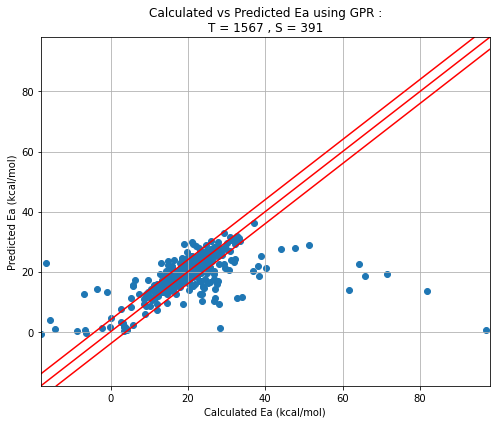

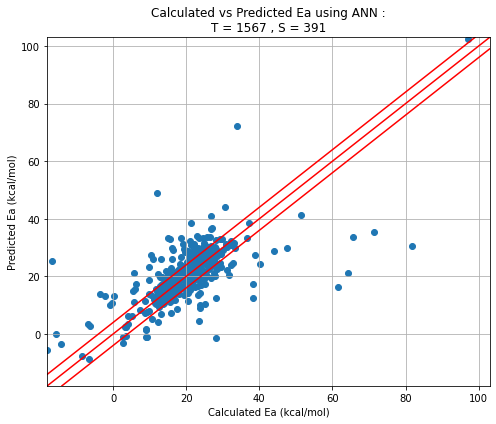

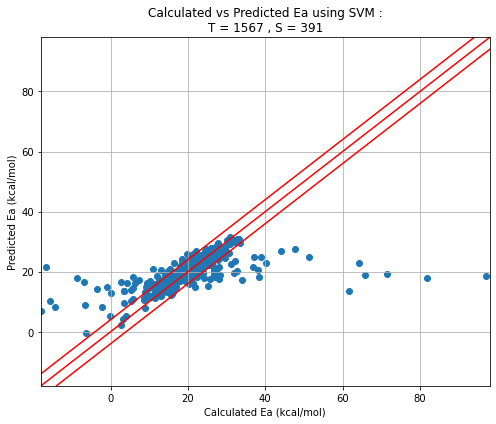

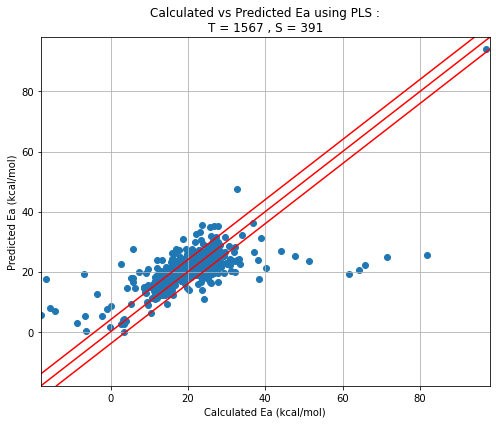

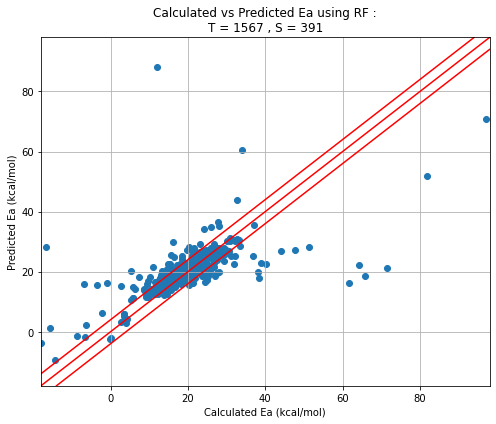

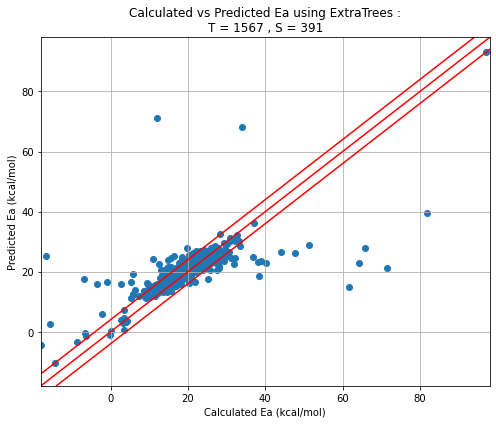

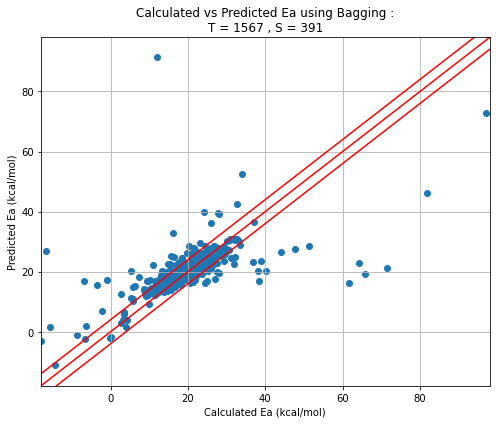

In [14]:
# Plot individual graphs and save plots
i=1
for x in models:
    fig=plt.figure(figsize=(7,6))
    num_list=[]
    num_list.extend(preds['Calc'])
    num_list.extend(preds[x])
    mini=math.floor(min(num_list))
    maxi=math.ceil(max(num_list))
    ax=fig.add_subplot()
    plt.scatter(preds['Calc'],preds[x])
    line = mlines.Line2D([mini,maxi], [mini, maxi], color='red')
    line1 = mlines.Line2D([mini,maxi - 4], [mini + 4, maxi], color='red')
    line2 = mlines.Line2D([mini + 4,maxi], [mini, maxi - 4], color='red')
    ax.add_line(line)
    ax.add_line(line1)
    ax.add_line(line2)
    plt.title(f"Calculated vs Predicted Ea using {x} :\nT = {str(len(train_set))} , S = {len(test_set)}")
    plt.xlabel("Calculated Ea (kcal/mol)")
    plt.ylabel("Predicted Ea (kcal/mol)")
    plt.xlim(mini,maxi)
    plt.ylim(mini,maxi)
    plt.grid(True)
    i=i+1
    plt.tight_layout()
    plt.savefig(f'{prefix}_{x}_plot.jpg')
    plt.show()

### Comments on the plots here